## Interpreting WAOutput using lisa.Stats (Example)

## Background

This notebook loads test results from different WA agenda executions using WA's python interface and provides some plots which can help you compare the results to see what changed. The developers generally use it to compare Android workload execution changes between kernel updates.

It has specific plotting functions for Jankbench, PCMark, and Geekbench contained in this notebook where they can be easily reused or modified for other workloads. The PCMark and Geekbench plots are mostly differentiated by what is filtered for plotting and the plotting function is useful for any tests which produce a 'score'.

## Understanding what you see
### Jankbench Results
Jankbench records a number of statistics about each frame rendered during test execution. The jankbench collector is able to open the database and add these results to the output from the WAOutput object. Here, we only use total_duration, which is the total time required to finish each frame. Each frame is annotated with a monotonically increasing id, so you can tell which order they were drawn in.

Each of the plots also come with a short stats dataframe overview showing:
+ count - How many frames are in the set
+ mean - regular mean of total_duration
+ geomean - geometric mean of total duration
+ std - standard deviation of the result set
+ min - minimum total_duration
+ 50% - 50th percentile (same as median) for total_duration
+ 99% - 99th percentile for total duration
+ max - maximum total_duration

All the plots show the same information, just in different ways. You may find some to be easier to interpret than others, so we include them all by default.

#### CDFs
By default, the CDF plot in this notebook shows a cumulative distribution function (https://en.wikipedia.org/wiki/Cumulative_distribution_function) for all frames drawn in a particular combination of kernel and test. You can specify a particular iteration if desired, but the default considers all frames in all iterations.

The plot is annotated with some additional lines.
+ There is a vertical line at the 99th percentile - this shows that 99% of all frames would be expected to complete before this line. This line is plotted in the same color as the CDF it refers to.
+ There is a vertical line placed at the user-specified threshold. The notebook defaults to this being 8ms, but it should be adjusted to match the target frame rate.


#### BoxPlots
This is the same as the plot above, except in boxplot form. The boxplot parameters are not changed from the default matplotlib ones.

The target frame rate render time is also drawn vertically.

#### FrameTime Plots
This is a different kind of plot, and here we only compare a single iteration. You can specify which iteration you use, the default is to take the first one.

This plot shows the total_duration on y axis and frames in render order on the x axis. The 99th percentile for each result set and the target frame time are drawn as horizontal lines. You can sometimes see significant divergence in consistent places in runs on these plots which can at least tell you where to look. If multiple runs have mostly the same shape but some divergences in consistent spots, there is probably something to investigate.

### Energy Plots

If I get some data, I'll try to reproduce these. We used to use boxplots to compare energy samples.


### Geekbench & PCMark Comparison Graphs
In interpreting the results, you will need at least some knowledge of confidence intervals and why we use a non-parametric test to determine them (hint: The results we see are usually not of a normal distribution).

The specific test used in the Lisa Stats object to compute a p-value is the Kolmogorov–Smirnov test, as this does not require your samples to come from data with a normal distribution. Wikipedia has more information at https://en.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test

As used here, this test tells you the likelyhood that the two result sets you are comparing (which are considered to both comprise a number of samples from an infinite set of test runs on that particular configuration) come from the same distribution - i.e. a value of 1.0 means that they come from the same distribution.

The important point is that __If the distribution is the same, then the results have no difference__ i.e. any difference you see in the aggregate statistics is very likely to be misleading and simply due to chance. 

__In order to have definitive results here, you should aim to have at least 30 samples of each distribution.__



## 

## 



In [1]:
from lisa.wa import WAOutput
from lisa.stats import Stats

import logging
from lisa.utils import setup_logging
setup_logging(level=logging.WARNING)

wa_output_path = '/opt/work/lisa/results/wltests/pixel4'
kernel_path = '/opt/work/eas/kernel_workspace/kernel_workspace/android-kernel/private/msm-google'


### Collect and plot WA Jankbench Results

In [2]:
from wa import RunOutput, discover_wa_outputs, Status, HostError

In [3]:
import sqlite3
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
from scipy import stats
%matplotlib inline

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

#### Open results and show available collectors

In [4]:
wa = WAOutput(wa_output_path, kernel_path=kernel_path)
list(wa.keys())

['jankbench', 'results', 'energy']

## 

#### Decide on frame timing targets for plotting and evaluating percentiles

In [5]:

# 16ms ~= 60Hz
# 12ms ~= 90Hz
#  8ms ~= 120Hz
threshold = 8.0


## 

#### Load up the Jankbench results from the specified dataset

In [6]:
# Collect all our result artifacts
collector = wa.get_collector('jankbench')
df = collector.df


In [7]:
# show the first ten rows
df

,frame_id,variable,value,unit,iteration,workload,id,tag,kernel
0,1,total_duration,27.068337,ms,1,jankbench,default-jankbench_list_view,iter_3,4.14.170-gc72771da3_audio-g3ab4335-ab32
1,2,total_duration,19.426523,ms,1,jankbench,default-jankbench_list_view,iter_3,4.14.170-gc72771da3_audio-g3ab4335-ab32
2,3,total_duration,4.794331,ms,1,jankbench,default-jankbench_list_view,iter_3,4.14.170-gc72771da3_audio-g3ab4335-ab32
3,4,total_duration,4.816895,ms,1,jankbench,default-jankbench_list_view,iter_3,4.14.170-gc72771da3_audio-g3ab4335-ab32
4,5,total_duration,4.369130,ms,1,jankbench,default-jankbench_list_view,iter_3,4.14.170-gc72771da3_audio-g3ab4335-ab32
...,...,...,...,...,...,...,...,...,...
75915,149,jank_frame,0.000000,,3,jankbench,default-jankbench_edit_text,iter_3,4.14.111_audio-g3ab4335-ab31
75916,150,jank_frame,0.000000,,3,jankbench,default-jankbench_edit_text,iter_3,4.14.111_audio-g3ab4335-ab31
75917,151,jank_frame,0.000000,,3,jankbench,default-jankbench_edit_text,iter_3,4.14.111_audio-g3ab4335-ab31
75918,152,jank_frame,0.000000,,3,jankbench,default-jankbench_edit_text,iter_3,4.14.111_audio-g3ab4335-ab31


### Obtain statistics using the Lisa Stats Object

In [8]:
jankbench_stats = Stats(df, ref_group={'kernel':df['kernel'].unique()[0]}, agg_cols=['iteration', 'frame_id'])
jankbench_stats.df

,id,kernel,tag,variable,workload,stat,value,unit,ci_minus,ci_plus
0,default-jankbench_edit_text,4.14.111_audio-g3ab4335-ab31,iter_3,jank_frame,jankbench,median,NaN,%,NaN,NaN
1,default-jankbench_edit_text,4.14.111_audio-g3ab4335-ab31,iter_3,jank_frame,jankbench,mean,-0.871460,%,NaN,NaN
2,default-jankbench_edit_text,4.14.111_audio-g3ab4335-ab31,iter_3,jank_frame,jankbench,std,-0.434760,%,NaN,NaN
3,default-jankbench_edit_text,4.14.111_audio-g3ab4335-ab31,iter_3,jank_frame,jankbench,count,0.879121,%,NaN,NaN
4,default-jankbench_edit_text,4.14.111_audio-g3ab4335-ab31,iter_3,total_duration,jankbench,median,-11.820807,%,NaN,NaN
5,default-jankbench_edit_text,4.14.111_audio-g3ab4335-ab31,iter_3,total_duration,jankbench,mean,-10.863575,%,NaN,NaN
6,default-jankbench_edit_text,4.14.111_audio-g3ab4335-ab31,iter_3,total_duration,jankbench,std,4.720619,%,NaN,NaN
7,default-jankbench_edit_text,4.14.111_audio-g3ab4335-ab31,iter_3,total_duration,jankbench,count,0.879121,%,NaN,NaN
8,default-jankbench_edit_text,4.14.111_audio-g3ab4335-ab31,iter_3,jank_frame,jankbench,ks2samp_test,1.000000,pval,NaN,NaN
9,default-jankbench_edit_text,4.14.111_audio-g3ab4335-ab31,iter_3,total_duration,jankbench,ks2samp_test,0.000000,pval,NaN,NaN


### Use the plotter from the Stats object to visualise jankbench results


[2021-01-28 18:22:16,305][py.warnings] WARNING  /opt/work/lisa/.lisa-venv-3.8/lib/python3.8/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)



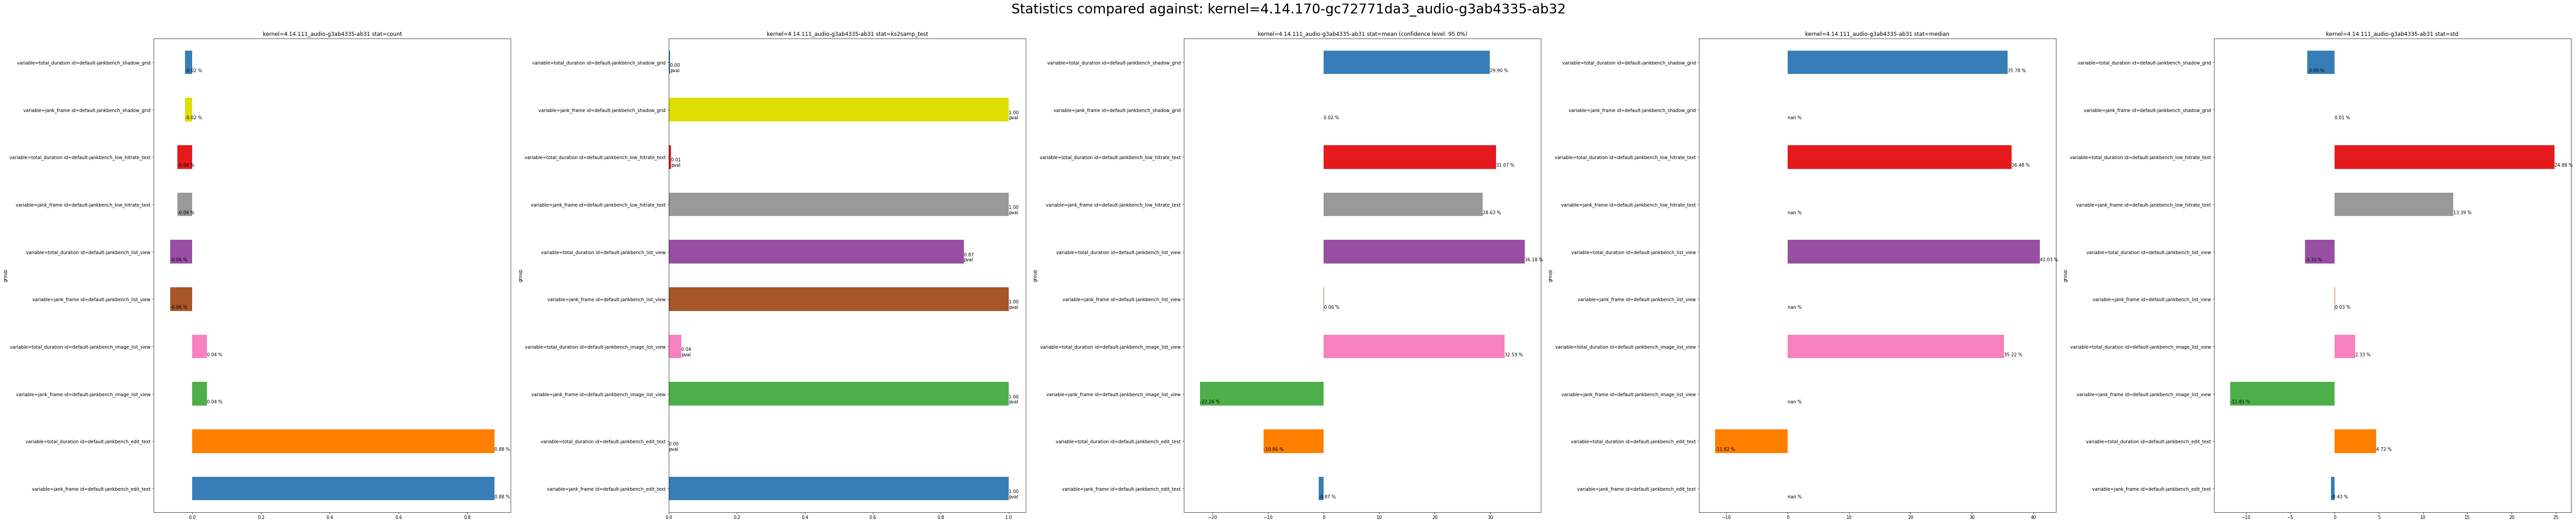

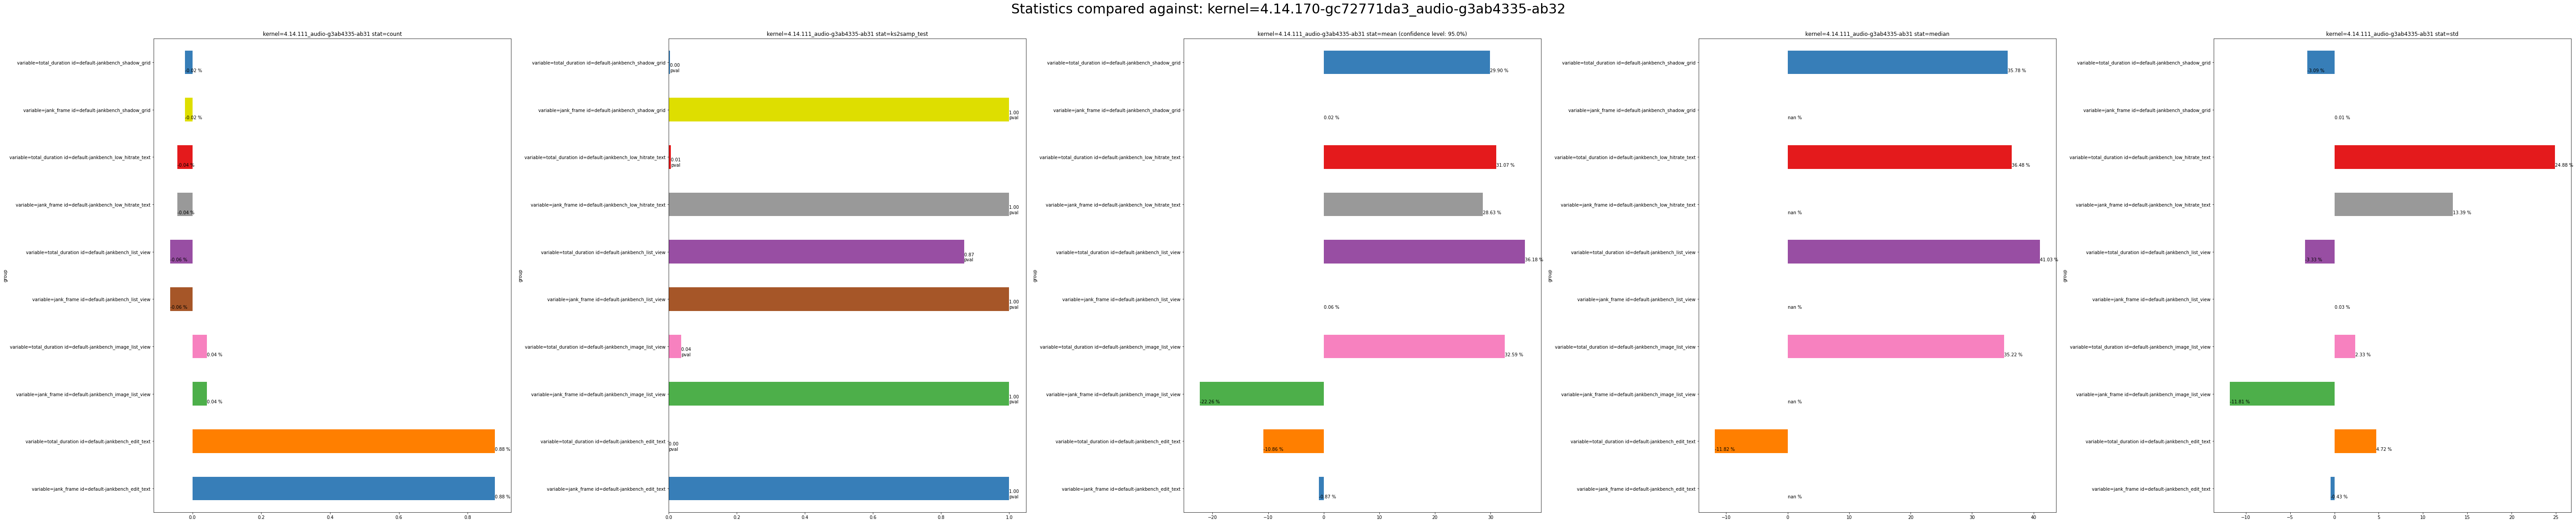

In [9]:
jankbench_stats.plot_stats()

### Plot Traditional Jankbench CDFs (like the old collector implementation)

In [10]:
def jankbench_frametimes_plot(ax, df, threshold, iteration):
    # Set up plot
    longest_frame = df['total_duration'].max()
    major_ticks = [ 4.0, 8.0, 12.0, 16.0, 32.0 ]
    minor_ticks = np.arange(0, longest_frame, 2)
    ax.set_yticks(major_ticks)
    ax.set_yticks(minor_ticks, minor=True)
    ax.grid(which='minor', alpha=0.2, color='grey', linestyle='dotted', linewidth=2)
    ax.grid(which='major', alpha=0.5, color='grey', linestyle='-', linewidth=2)
    ax.axhline(threshold, alpha=0.5, color='green', linestyle='dashed', linewidth=2)
    ax.set_ylim((0.0, longest_frame))
    # draw frame render times
    if iteration is not None:
        ax.set_title("{} (frame times for iteration {})".format(df['id'].unique()[0], iteration))
    else:
        ax.set_title("{} (all collected frame times)".format(df['id'].unique()[0]))
    display_df = pd.DataFrame()
    for kernel in df['kernel'].unique():
        tmp_df = df[df['kernel'] == kernel]
        nn_q = df[df['kernel'] == kernel]['total_duration'].quantile(0.99)
        tmp_df.plot(x='frame_id', y='total_duration', ax=ax, label="{}: 99th: {:2.4}ms".format(kernel ,nn_q))
        color = ax.lines[-1].get_color()
        ax.axhline(nn_q, color=color)
        display_df[kernel] = pd.Series(df[df['kernel'] == kernel]['total_duration'].values)
    ax.legend(loc='upper right')
    return display_df
    

def jankbench_cdf_plot(ax, df, threshold, iteration, bins=500):
    # set up plot
    longest_frame = df['total_duration'].max()
    major_ticks = [ 4.0, 8.0, 12.0, 16.0, 32.0 ]
    minor_ticks = np.arange(0, longest_frame, 2)
    ax.set_xticks(major_ticks)
    ax.set_xticks(minor_ticks, minor=True)
    ax.grid(which='minor', alpha=0.2, color='grey', linestyle='dotted', linewidth=2)
    ax.grid(which='major', alpha=0.5, color='grey', linestyle='-', linewidth=2)
    ax.axvline(threshold, alpha=0.5, color='green', linestyle='dashed', linewidth=2)
    ax.set_xlim((0.0, longest_frame))
    if iteration is None:
        ax.set_title("{} (aggregated frame times)".format(df['id'].unique()[0]))
    else:
        ax.set_title("{} (frame times for iteration {})".format(df['id'].unique()[0], iteration))      
    # plot the CDFs
    display_df = pd.DataFrame()
    for kernel in df['kernel'].unique():
        # calculate the 99th quantile for this kernel
        nn_q = df[df['kernel'] == kernel]['total_duration'].quantile(0.99)
        n,b,p = ax.hist(df[df['kernel'] == kernel]['total_duration'], label="{}: 99th: {:2.4}ms".format(kernel ,nn_q),
                bins=bins, cumulative=True, density=True, histtype='step', linewidth=2)
        # pick out the last colour used and draw the quantile line with it
        ax.axvline(nn_q, color=p[0].get_edgecolor())
        display_df[kernel] = pd.Series(df[df['kernel'] == kernel]['total_duration'].values)
    ax.legend(loc='lower right')
    return display_df

def jankbench_box_plot(ax, df, threshold, iteration):
    display_df = pd.DataFrame()
    columns = []
    for kernel in df['kernel'].unique():
        columns.append(kernel)
        display_df[kernel] = pd.Series(df[df['kernel'] == kernel]['total_duration'].values)
    # draw boxplots
    if iteration is not None:
        ax.set_title("{} (frame times for iteration {})".format(df['id'].unique()[0], iteration))      
    else:
        ax.set_title("{} (frame times for all iterations)".format(df['id'].unique()[0]))      
    display_df.boxplot(column=columns, ax=ax, vert=False)
    ax.axvline(threshold, alpha=0.5, color='green', linestyle='dashed', linewidth=2)
    return display_df

def jankbench_plot(workload_name, df, threshold, kind='cdf', ax=None, summarize=False, iteration=None):
    if kind not in ['cdf', 'boxplot', 'frametimes']:
        return
    
    # encapsulate fig
    def __display_fig(fig):
        if fig is not None:
            display(fig)
    # calculate a Geomean line for describe output
    def __summarize(describe_df):
        # display description including geomean
        summary_df = describe_df.describe(percentiles=[0.5, 0.99]).transpose()
        summary_df.insert(2, 'geomean', value=0.0, allow_duplicates=True)
        for kernel in describe_df:
            summary_df.at[kernel, 'geomean'] = stats.gmean(describe_df[kernel].dropna(), axis=0)
        return summary_df
    if ax is None:
        # set up figure
        fig = plt.figure(figsize=(20,10))
        ax = plt.axes()
    else:
        fig = None

    plot_df = df[df['id'] == workload_name]
    if iteration is not None:
        plot_df = plot_df[plot_df['iteration'] == iteration]

    # call out to the correct plotter
    # each plotter is expected to return a dataframe containing the data which
    # was actually used to draw the plot after filtering.
    # Dataframe should be like:
    #     | kernel 1                     | kernel 2                    |
    # ------------------------------------------------------------------
    #  1  |  total_duration from frame 1 | total_duration from frame 1 |
    #  2  |  NaN                         | total_duration from frame 2 |
    #
    # We expect each kernel to have a column, total_duration in the rows,
    # Gaps filled with NaN. We will use df.describe if a summary was
    # requested and add in a geomean line as well.
    if kind == 'cdf':
        describe_df = jankbench_cdf_plot(ax, plot_df, threshold, iteration)
    elif kind == 'boxplot':
        describe_df = jankbench_box_plot(ax, plot_df, threshold, iteration)
    elif kind == 'frametimes':
        describe_df = jankbench_frametimes_plot(ax, plot_df, threshold, iteration)
    
    __display_fig(fig)
    if summarize == True:
        display(__summarize(describe_df))

    if fig is not None:
        plt.close(fig)


In [11]:
# Convert into old-style dataframe
raw_df = df.pivot(index=['iteration', 'id', 'kernel', 'frame_id'], columns=['variable'])
raw_df = raw_df['value'].reset_index()
raw_df.columns.name = None
raw_df[:5]

,iteration,id,kernel,frame_id,jank_frame,total_duration
0,1,default-jankbench_edit_text,4.14.111_audio-g3ab4335-ab31,1,1.0,26.924210
1,1,default-jankbench_edit_text,4.14.111_audio-g3ab4335-ab31,2,0.0,20.372788
2,1,default-jankbench_edit_text,4.14.111_audio-g3ab4335-ab31,3,0.0,4.277677
3,1,default-jankbench_edit_text,4.14.111_audio-g3ab4335-ab31,4,0.0,5.747801
4,1,default-jankbench_edit_text,4.14.111_audio-g3ab4335-ab31,5,0.0,5.740746


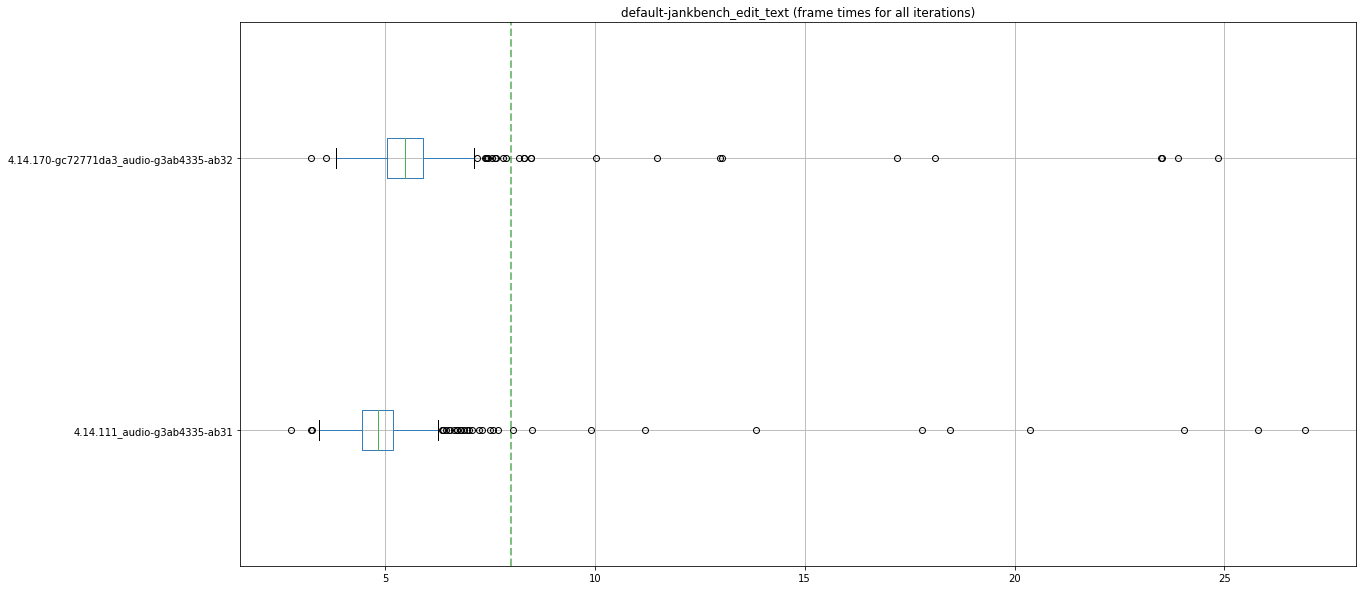

,count,mean,geomean,std,min,50%,99%,max
4.14.111_audio-g3ab4335-ab31,459.0,5.159585,4.962689,2.207224,2.755872,4.835075,18.074898,26.924210
4.14.170-gc72771da3_audio-g3ab4335-ab32,455.0,5.788414,5.610466,2.107726,3.243944,5.483238,17.608676,24.845349


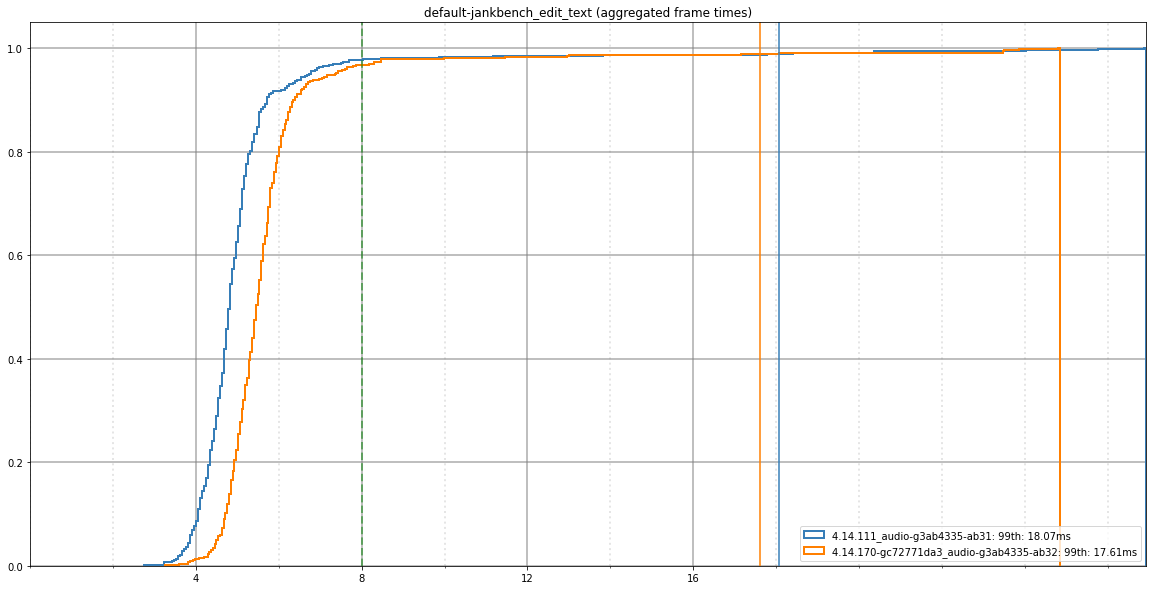

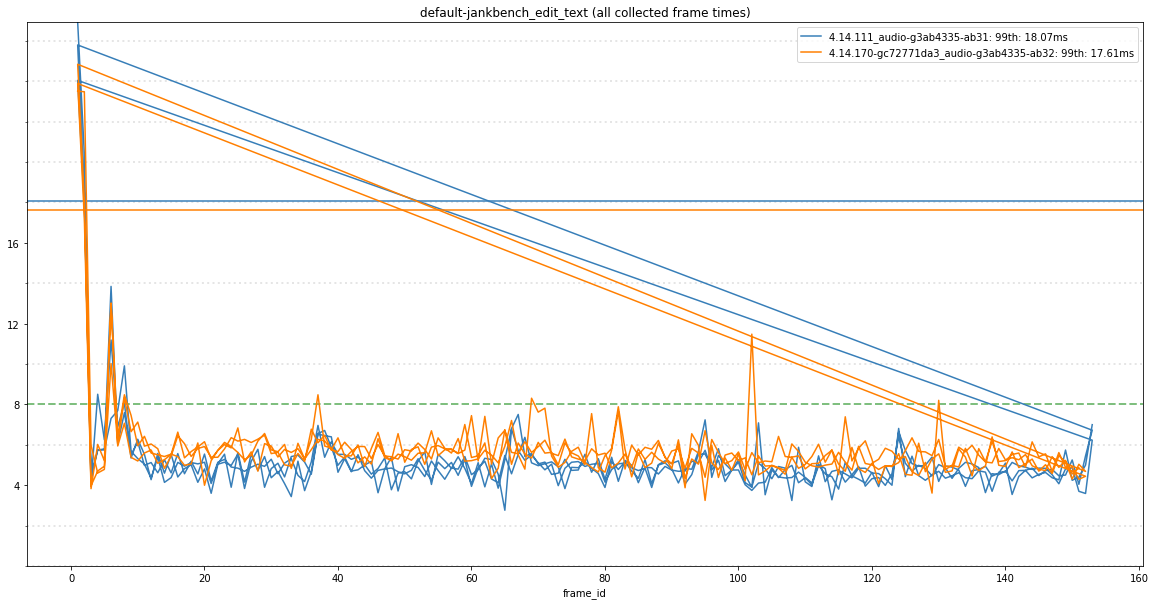

,count,mean,geomean,std,min,50%,99%,max
4.14.111_audio-g3ab4335-ab31,459.0,5.159585,4.962689,2.207224,2.755872,4.835075,18.074898,26.924210
4.14.170-gc72771da3_audio-g3ab4335-ab32,455.0,5.788414,5.610466,2.107726,3.243944,5.483238,17.608676,24.845349


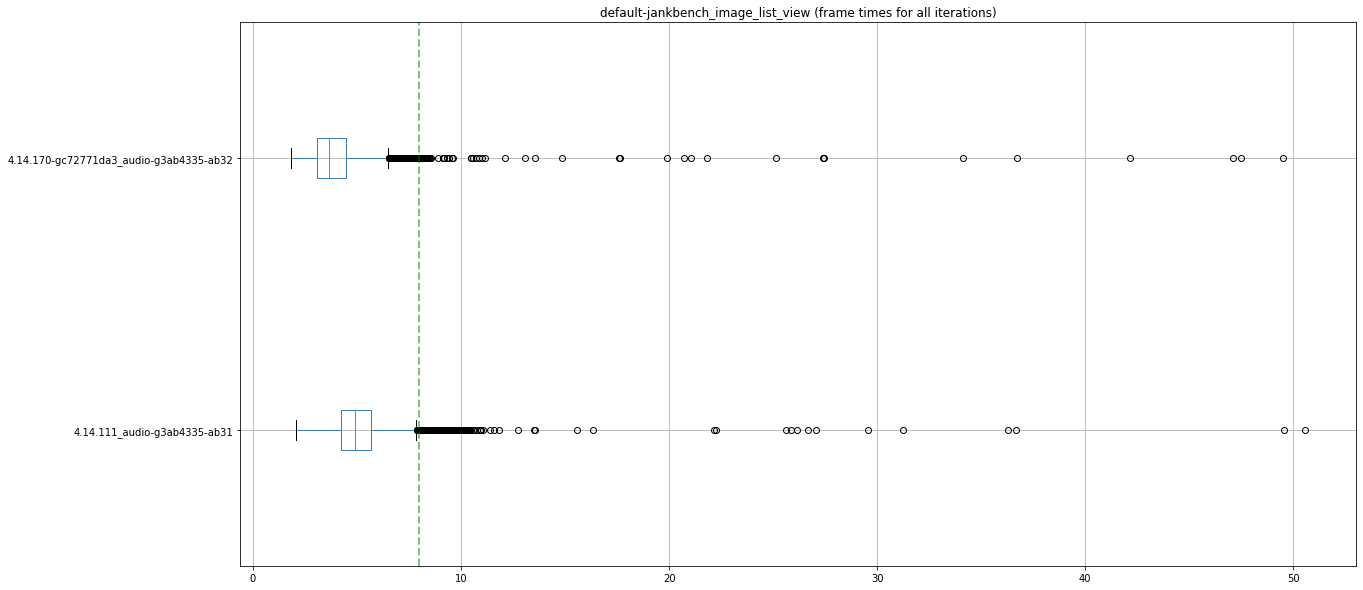

,count,mean,geomean,std,min,50%,99%,max
4.14.111_audio-g3ab4335-ab31,4662.0,5.349092,5.123844,2.109163,2.076190,4.925880,10.093450,50.569232
4.14.170-gc72771da3_audio-g3ab4335-ab32,4660.0,4.034273,3.809810,2.061180,1.816144,3.642991,8.172914,49.497869


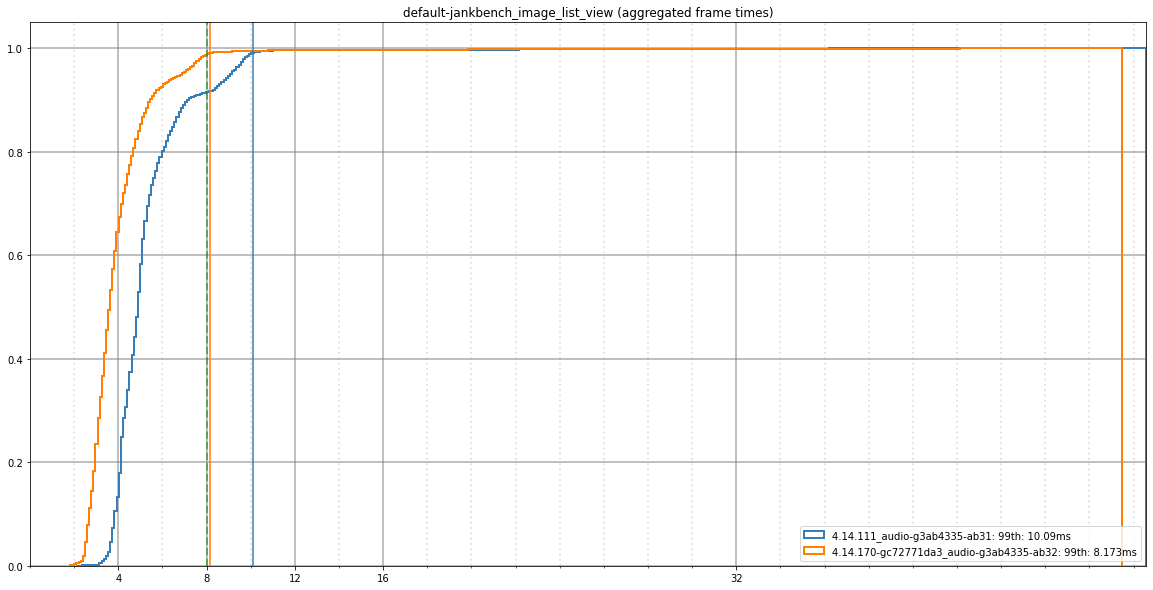

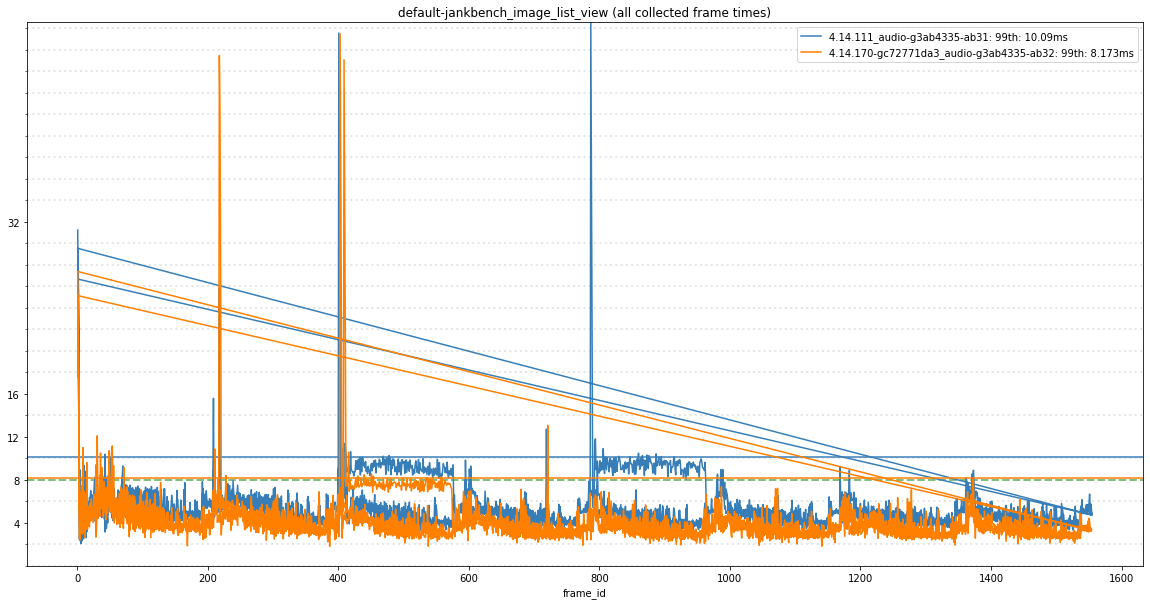

,count,mean,geomean,std,min,50%,99%,max
4.14.111_audio-g3ab4335-ab31,4662.0,5.349092,5.123844,2.109163,2.076190,4.925880,10.093450,50.569232
4.14.170-gc72771da3_audio-g3ab4335-ab32,4660.0,4.034273,3.809810,2.061180,1.816144,3.642991,8.172914,49.497869


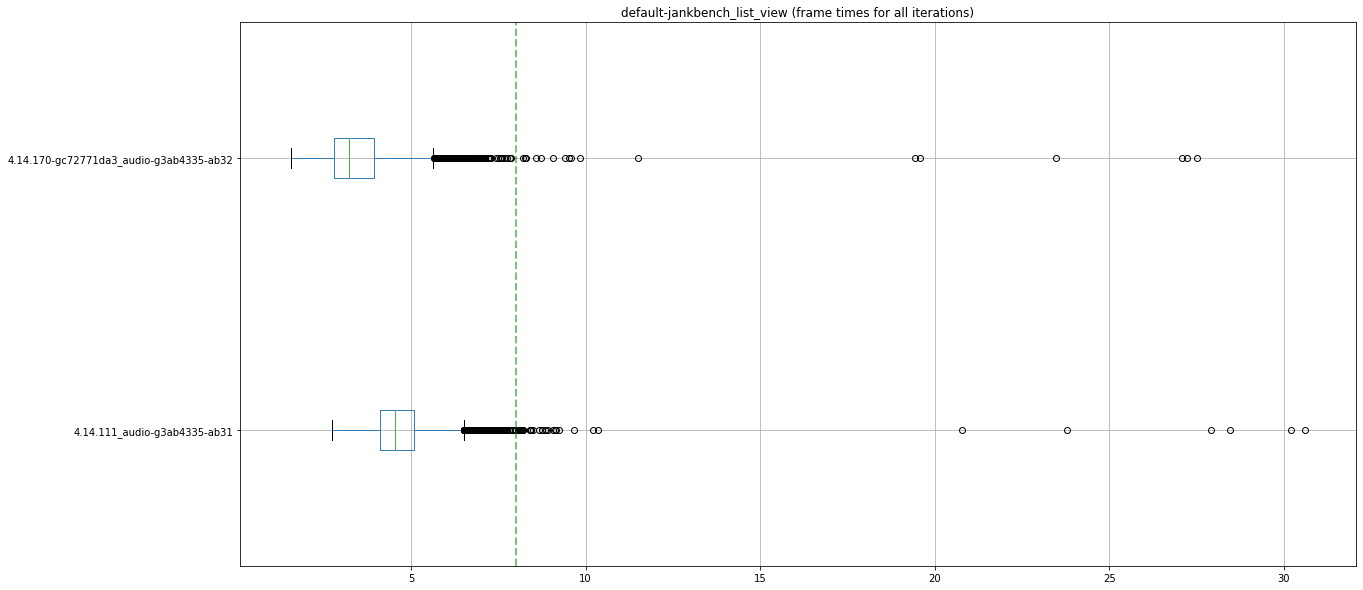

,count,mean,geomean,std,min,50%,99%,max
4.14.111_audio-g3ab4335-ab31,4618.0,4.776866,4.685203,1.203624,2.726122,4.540234,7.692553,30.610042
4.14.170-gc72771da3_audio-g3ab4335-ab32,4618.0,3.508115,3.369581,1.245403,1.552157,3.220237,6.828499,27.517423


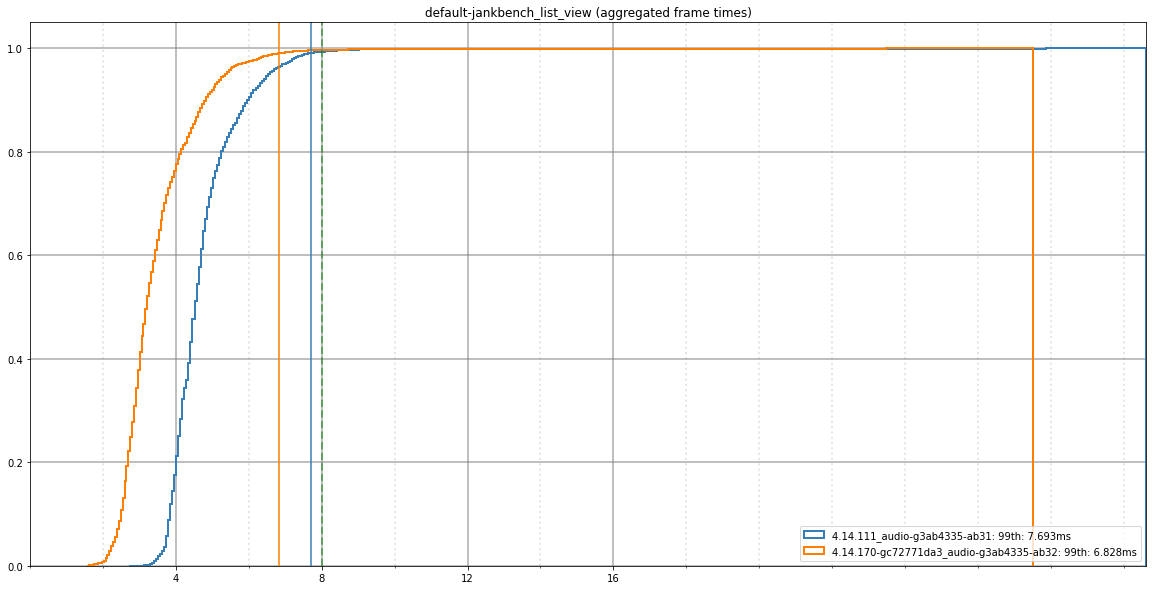

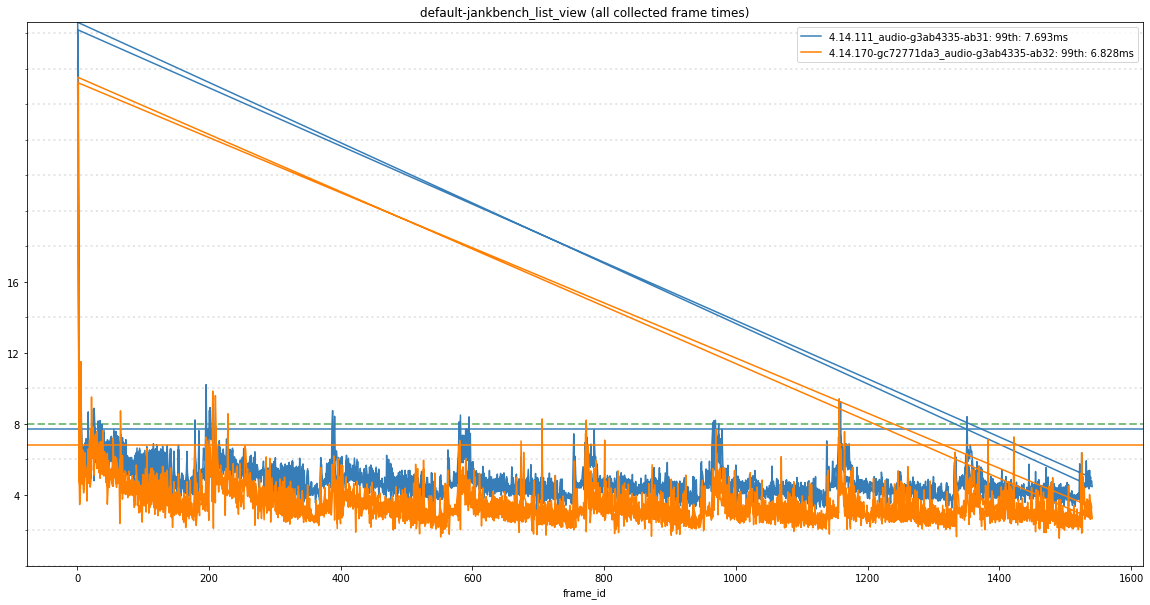

,count,mean,geomean,std,min,50%,99%,max
4.14.111_audio-g3ab4335-ab31,4618.0,4.776866,4.685203,1.203624,2.726122,4.540234,7.692553,30.610042
4.14.170-gc72771da3_audio-g3ab4335-ab32,4618.0,3.508115,3.369581,1.245403,1.552157,3.220237,6.828499,27.517423


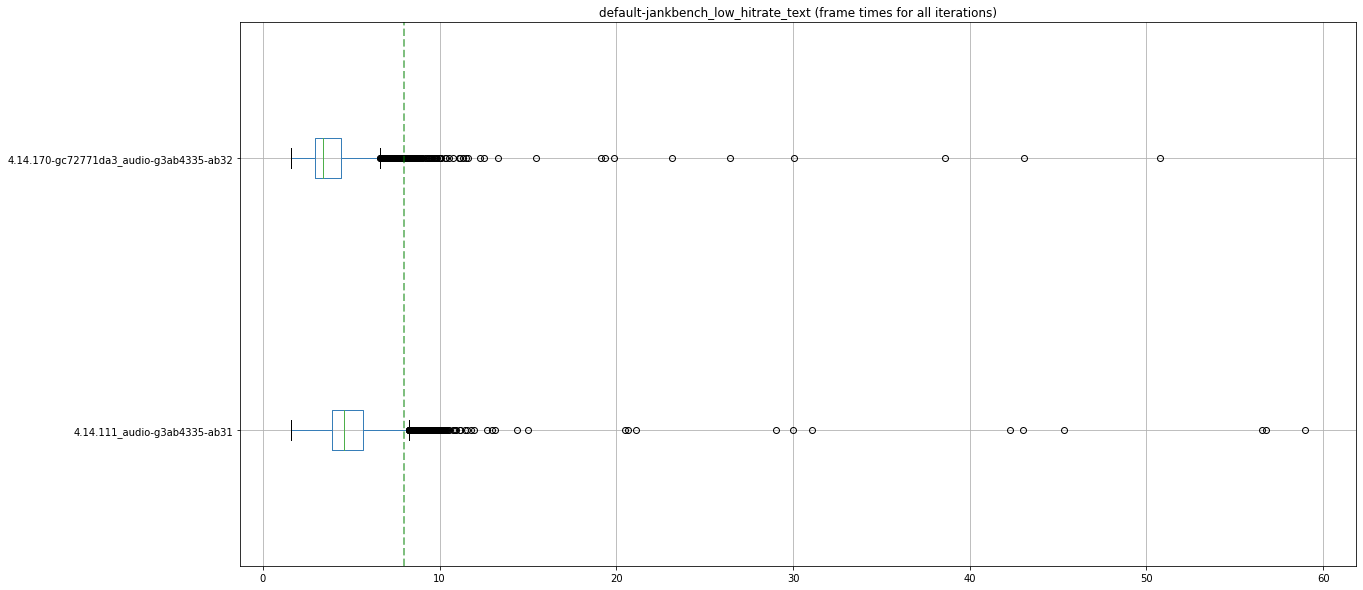

,count,mean,geomean,std,min,50%,99%,max
4.14.111_audio-g3ab4335-ab31,4619.0,5.308539,4.981320,2.586923,1.609865,4.605182,10.141739,58.985066
4.14.170-gc72771da3_audio-g3ab4335-ab32,4619.0,4.050482,3.755365,2.071886,1.570313,3.374441,8.874638,50.738612


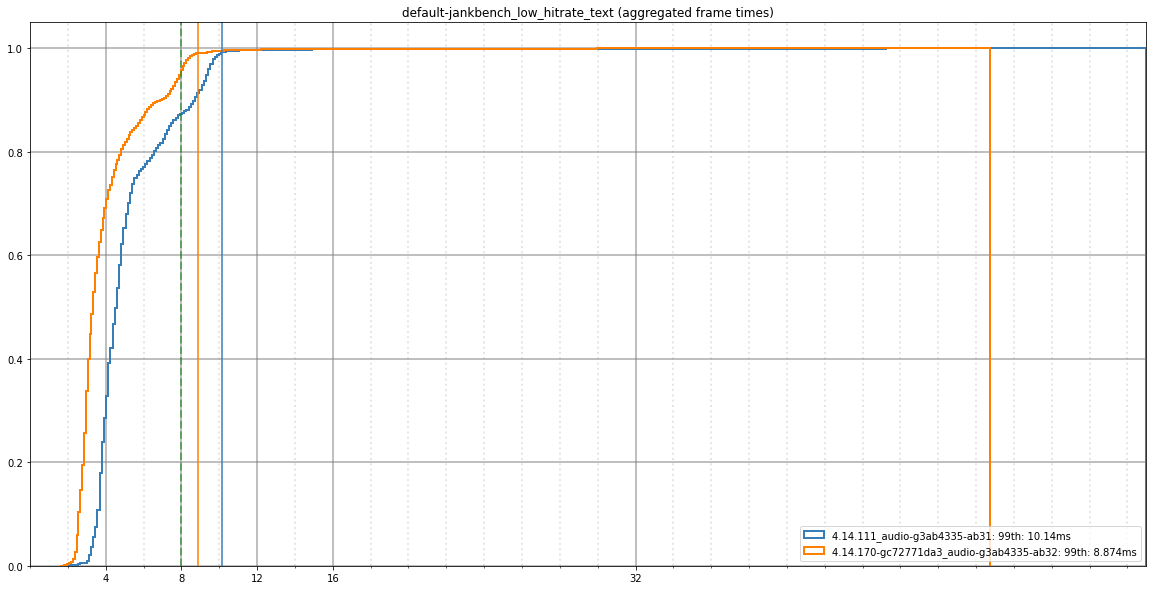

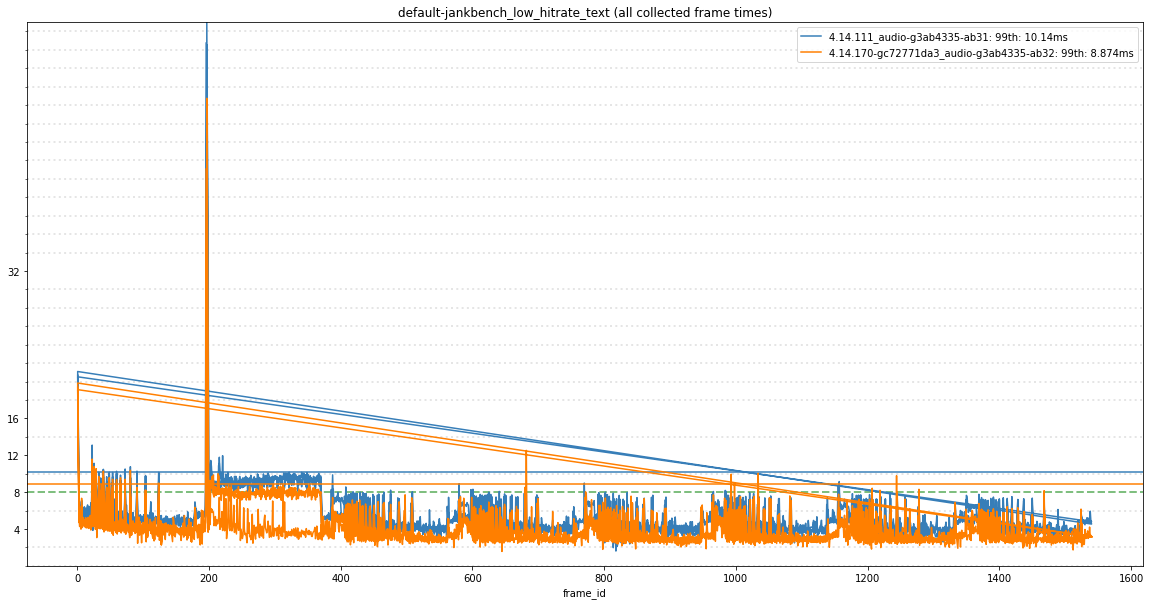

,count,mean,geomean,std,min,50%,99%,max
4.14.111_audio-g3ab4335-ab31,4619.0,5.308539,4.981320,2.586923,1.609865,4.605182,10.141739,58.985066
4.14.170-gc72771da3_audio-g3ab4335-ab32,4619.0,4.050482,3.755365,2.071886,1.570313,3.374441,8.874638,50.738612


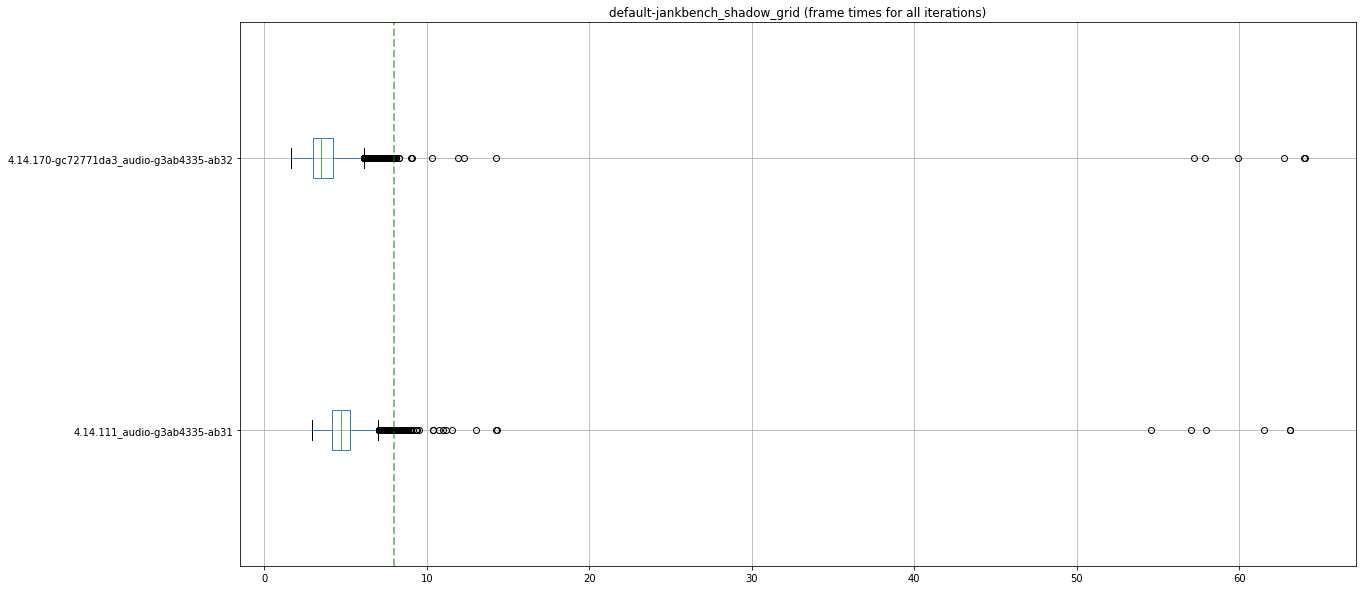

,count,mean,geomean,std,min,50%,99%,max
4.14.111_audio-g3ab4335-ab31,4622.0,4.935257,4.781114,2.230878,2.952212,4.741876,8.056605,63.128868
4.14.170-gc72771da3_audio-g3ab4335-ab32,4622.0,3.799410,3.618140,2.302113,1.621600,3.492878,7.114644,64.061386


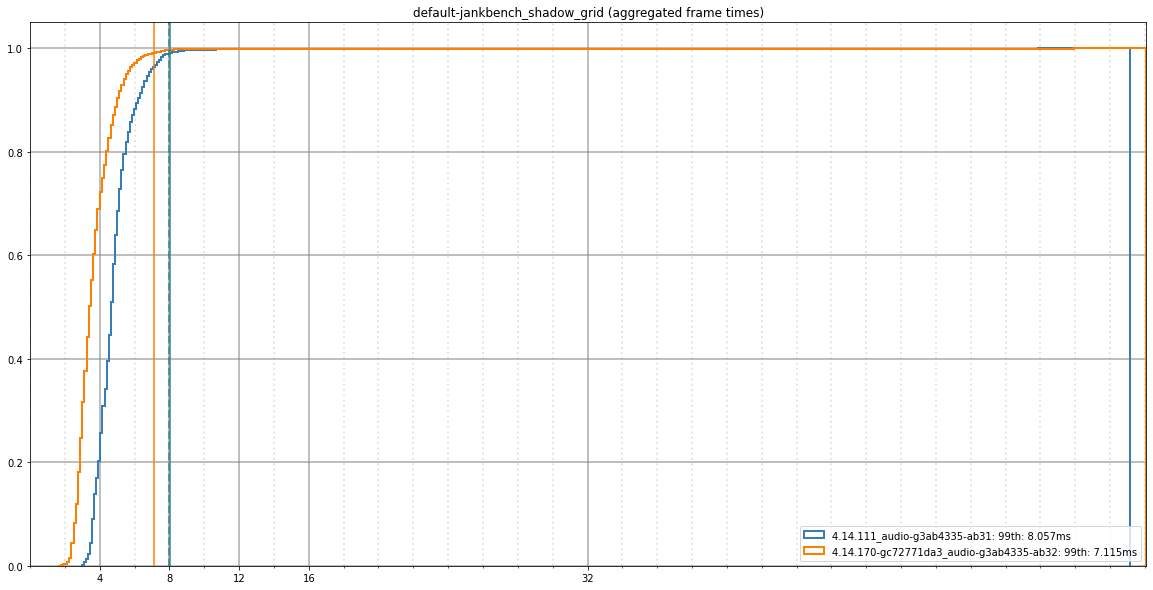

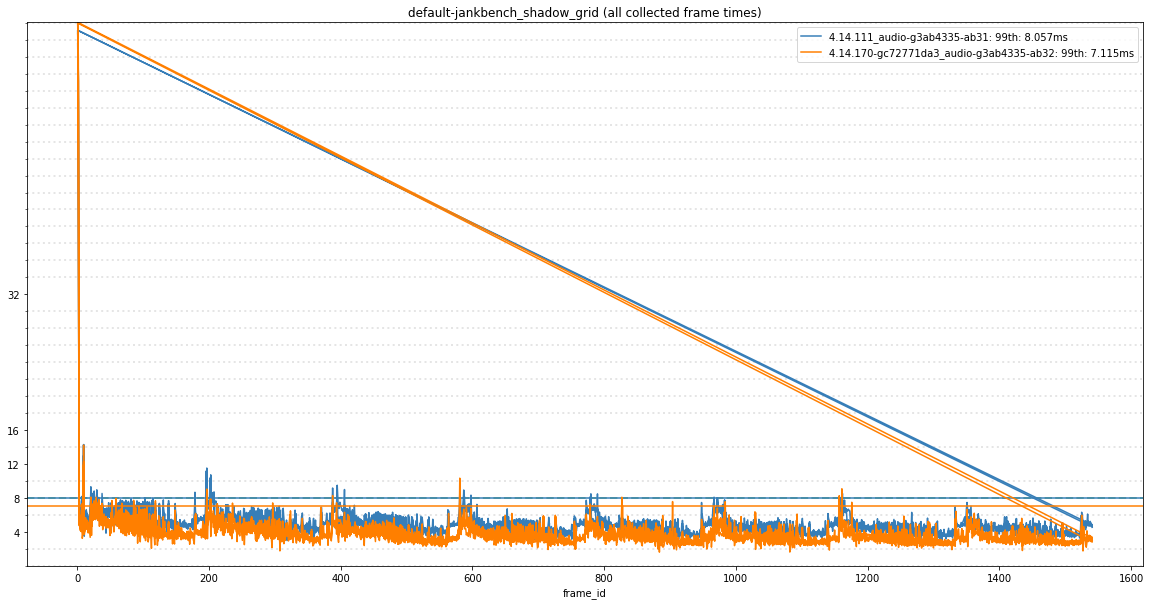

,count,mean,geomean,std,min,50%,99%,max
4.14.111_audio-g3ab4335-ab31,4622.0,4.935257,4.781114,2.230878,2.952212,4.741876,8.056605,63.128868
4.14.170-gc72771da3_audio-g3ab4335-ab32,4622.0,3.799410,3.618140,2.302113,1.621600,3.492878,7.114644,64.061386


In [12]:
# show plots for each comparable pair, by workload
for workload_name in raw_df['id'].unique():
    # aggregated
    jankbench_plot(workload_name, raw_df, threshold, kind='boxplot', summarize=True)
    # aggregated
    jankbench_plot(workload_name, raw_df, threshold, kind='cdf')
    # iteration 1
    jankbench_plot(workload_name, raw_df, threshold, kind='frametimes', summarize=True)#, iteration=1)


## Energy (not implemented yet)

## Overall Statistics

#### Plotting Function

In [13]:
def plot_stats(df, description, stat='mean', confidence='ks2samp_test', ax=None):
    alpha = 'alpha'
    tmp_df = df.copy()
    tmp_df[alpha] = 1.0-tmp_df[confidence]
    
    # encapsulate fig
    def __display_fig(fig):
        if fig is not None:
            display(fig)
    
    if ax is None:
        # set up figure
        fig = plt.figure(figsize=(20,20))
        ax = plt.axes()
    else:
        fig = None
    ax.set_title("{} Stat={}".format(description, stat))
    y_size = len(tmp_df)
    ax.set_ylim(bottom=len(tmp_df), top = -1)
    ax.set_xlim(left=tmp_df[stat].min(), right=tmp_df[stat].max())
    x_range = tmp_df[stat].max() - tmp_df[stat].min()
    y_pos = 0.0
    labels = []
    for index, row in tmp_df.iterrows():
        if row[stat] < 0:
            left = row[stat]
            text_pos = 0.0
            ax.text((x_range/100.0), y_pos, "p-val: {:4.2f} ({})".format(row[confidence], confidence))
        else:
            left = 0.0
            ax.text(-(x_range/100.0), y_pos, "p-val: {:4.2f} ({})".format(row[confidence], confidence), horizontalalignment='right')
        ax.barh(y_pos, abs(row[stat]), left=left, align='center', alpha=row[alpha])
        ax.barh(y_pos, abs(row[stat]), left=left, align='center', linewidth=1.0, fill=False)
        y_pos += 1.0
        labels.append(index)
    ax.set_yticks(np.arange(y_pos))
    ax.set_yticklabels(labels)
    __display_fig(fig)
    if fig is not None:
        plt.close(fig)
    

#### Read Results from dataset

In [14]:
results_collector = wa.get_collector('results')
results = results_collector.df

In [15]:
# We will assume that the first kernel is the reference,
# but be careful to make sure you select the desired one
# here as it influences the comparisons below.
available_kernels = list(results['kernel'].unique())
ref = available_kernels[1]
print("Kernel reference:", ref)
# These are the other kernels available
available_kernels.remove(ref)
print("Results for {}".format(available_kernels))

Kernel reference: 4.14.111_audio-g3ab4335-ab31
Results for ['4.14.170-gc72771da3_audio-g3ab4335-ab32']


## Geekbench Results

In [16]:
stats = Stats(results[results['workload'] == 'geekbench'], ref_group={'kernel':ref}, agg_cols=['iteration'])

In [17]:
available_stats = stats.df['stat'].unique()
print("Available Stats:")
for stat in available_stats:
    print("",stat)

[2021-01-28 18:22:32,941][lisa.stats.Stats] WARNING  Sample size smaller than 30 is being used, the mean confidence interval will only be accurate if the data is normally distributed: 3 samples for group id=default-geekbench, kernel=4.14.170-gc72771da3_audio-g3ab4335-ab32, metric=score, tag=iter_3, unit=, workload=geekbench
[2021-01-28 18:22:32,944][lisa.stats.Stats] WARNING  Sample size smaller than 30 is being used, the mean confidence interval will only be accurate if the data is normally distributed: 3 samples for group id=default-geekbench, kernel=4.14.170-gc72771da3_audio-g3ab4335-ab32, metric=multicore_score, tag=iter_3, unit=, workload=geekbench
[2021-01-28 18:22:32,947][lisa.stats.Stats] WARNING  Sample size smaller than 30 is being used, the mean confidence interval will only be accurate if the data is normally distributed: 3 samples for group id=default-geekbench, kernel=4.14.170-gc72771da3_audio-g3ab4335-ab32, metric=Single-Core_score, tag=iter_3, unit=, workload=geekbench


Available Stats:
 median
 mean
 std
 count
 ks2samp_test


### Split into single and multi-core results for display

In [18]:
single = []
multi = []
for metric in stats.df['metric'].unique():
    if metric.startswith('Multi-Core'):
        multi.append(metric)
    elif metric.startswith('Single-Core'):
        single.append(metric)
        
multi_df = stats.df[stats.df['metric'].isin(multi)]
single_df = stats.df[stats.df['metric'].isin(single)]        

In [19]:
results.to_parquet('df.parquet')

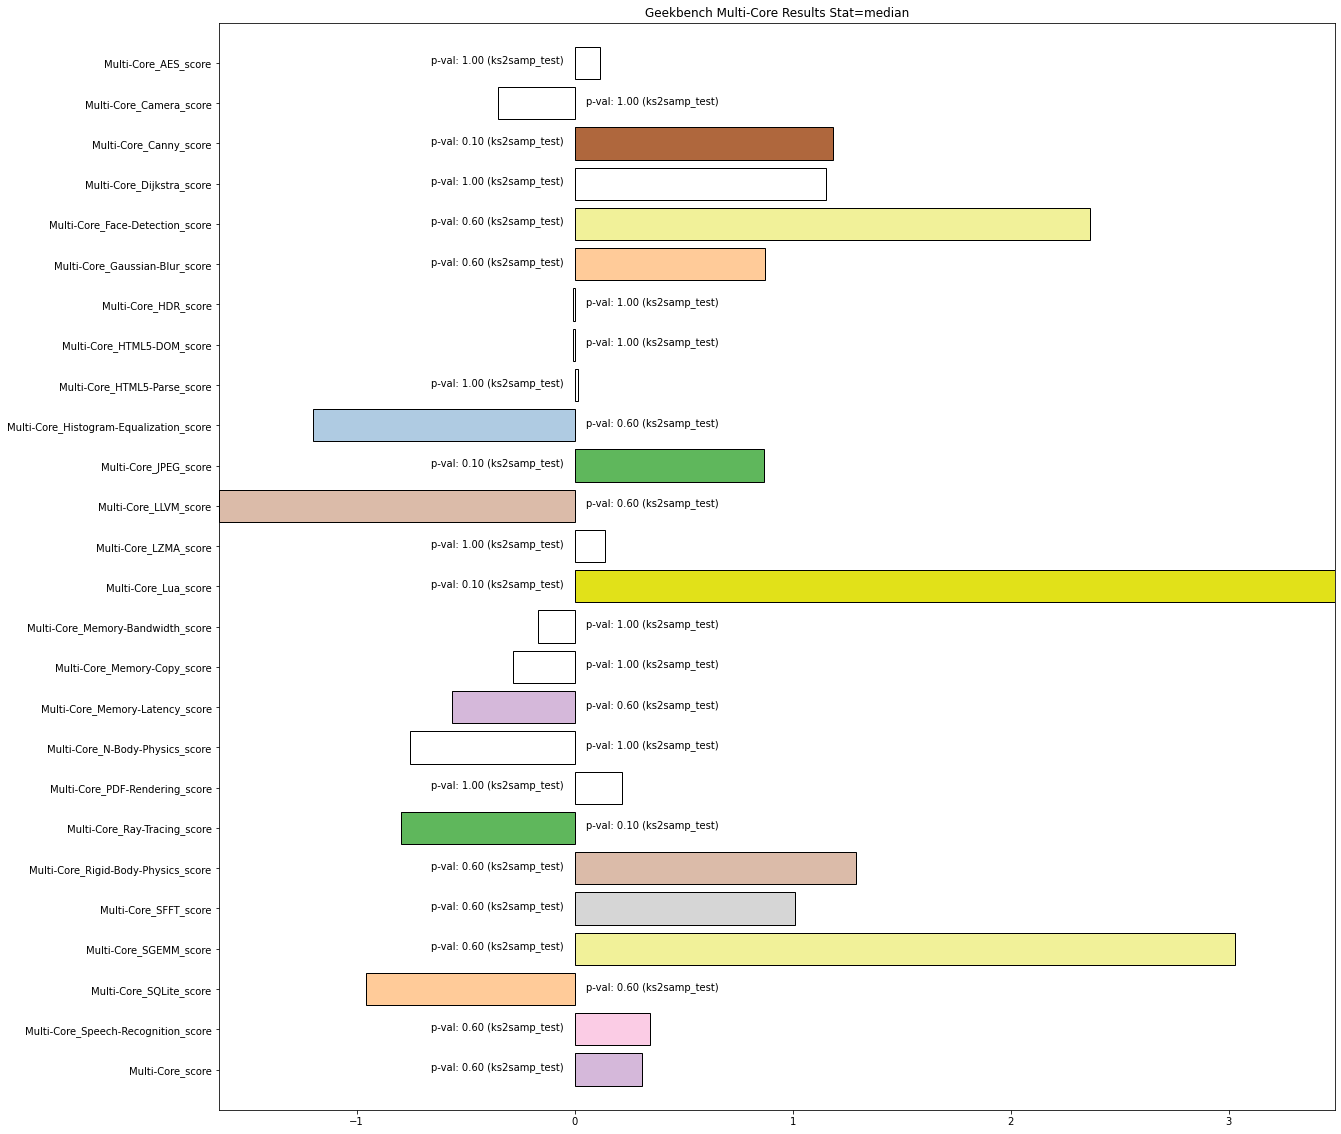

stat,count,ks2samp_test,mean,median,std
metric,,,,,
Multi-Core_AES_score,0.0,1.0,0.400534,0.114074,-85.134655
Multi-Core_Camera_score,0.0,1.0,-0.178661,-0.349925,325.538627
Multi-Core_Canny_score,0.0,0.1,1.220860,1.182579,-73.904969
Multi-Core_Dijkstra_score,0.0,1.0,-0.473843,1.152475,-23.763132
Multi-Core_Face-Detection_score,0.0,0.6,1.872144,2.361738,-94.890229
Multi-Core_Gaussian-Blur_score,0.0,0.6,1.589511,0.870701,85.865210
Multi-Core_HDR_score,0.0,1.0,0.056884,-0.005875,-0.353662
Multi-Core_HTML5-DOM_score,0.0,1.0,0.020978,-0.008973,-0.447430
Multi-Core_HTML5-Parse_score,0.0,1.0,0.251763,0.013568,-10.405158


In [20]:
plot_df = multi_df.pivot_table(index='metric', columns='stat', values='value')
plot_stats(plot_df, 'Geekbench Multi-Core Results', stat='median')
display(plot_df)

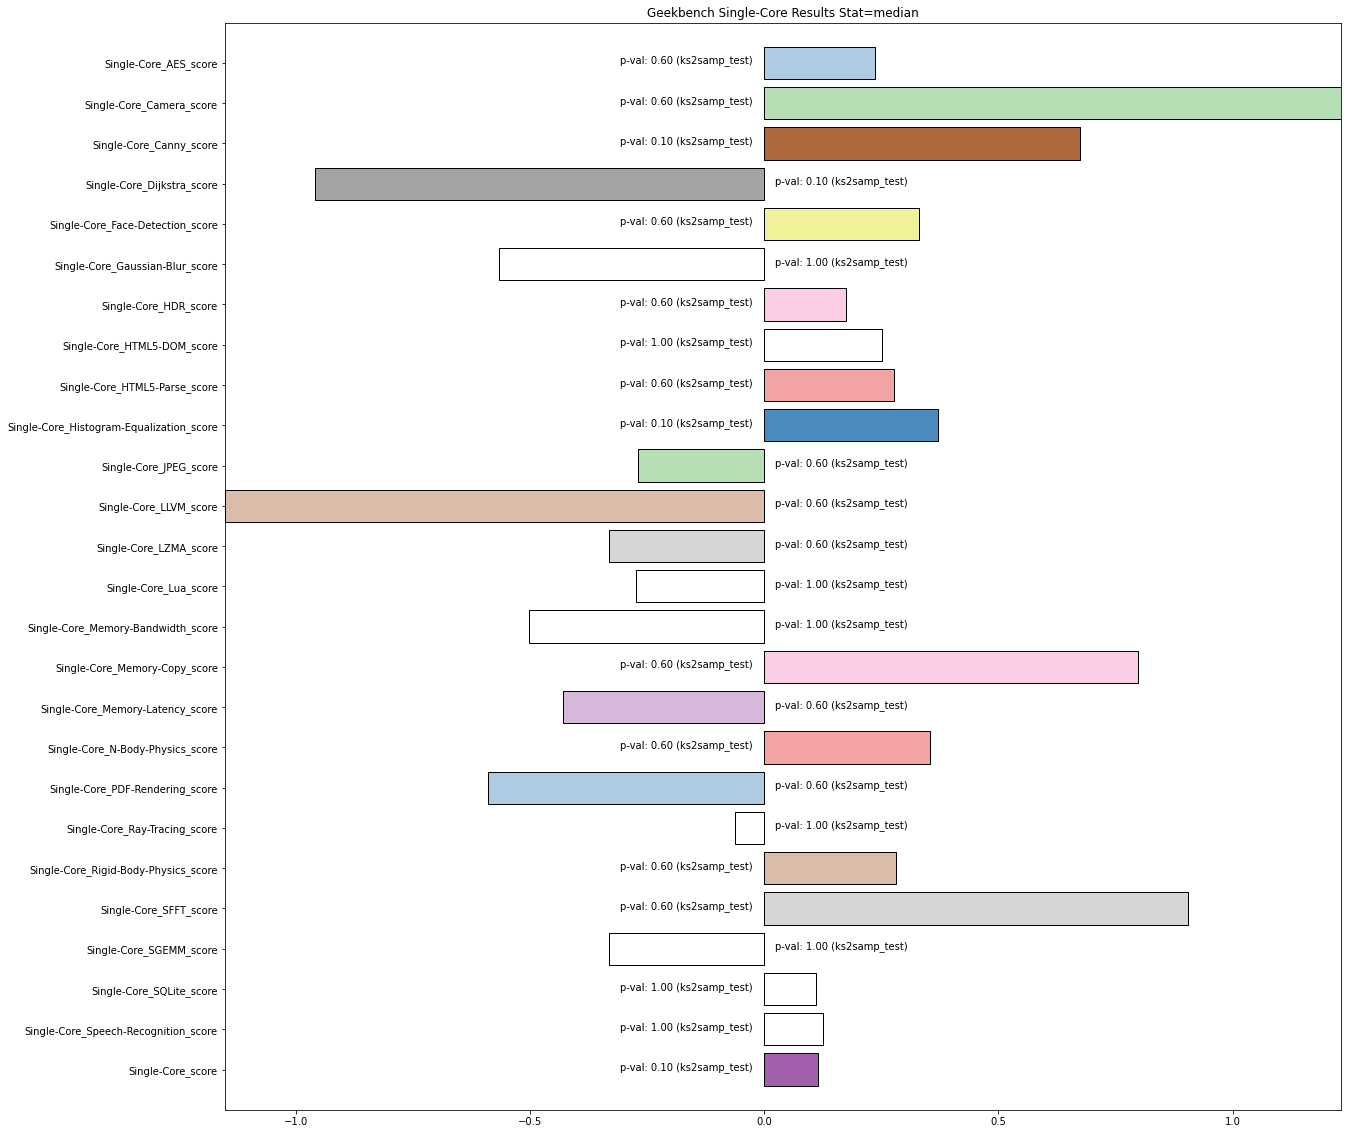

stat,count,ks2samp_test,mean,median,std
metric,,,,,
Single-Core_AES_score,0.0,0.6,0.118507,0.237248,-67.049821
Single-Core_Camera_score,0.0,0.6,0.717013,1.231114,161.998039
Single-Core_Canny_score,0.0,0.1,0.592194,0.673673,-78.817036
Single-Core_Dijkstra_score,0.0,0.1,-1.378636,-0.959233,182.687874
Single-Core_Face-Detection_score,0.0,0.6,0.402562,0.329580,80.526807
Single-Core_Gaussian-Blur_score,0.0,1.0,0.342266,-0.565956,41.433929
Single-Core_HDR_score,0.0,0.6,0.102429,0.175670,-7.203927
Single-Core_HTML5-DOM_score,0.0,1.0,-0.013978,0.251889,-31.649326
Single-Core_HTML5-Parse_score,0.0,0.6,0.359513,0.276932,-38.430721


In [21]:
plot_df = single_df.pivot_table(index='metric', columns='stat', values='value')
plot_stats(plot_df, 'Geekbench Single-Core Results', stat='median')
display(plot_df)

## PCMark Results

In [22]:
stats = Stats(results[results['workload'] == 'pcmark'], ref_group={'kernel':ref}, agg_cols=['iteration'])

In [23]:
available_stats = stats.df['stat'].unique()
print("Available Stats:")
for stat in available_stats:
    print("",stat)

[2021-01-28 18:22:37,508][lisa.stats.Stats] WARNING  Sample size smaller than 30 is being used, the mean confidence interval will only be accurate if the data is normally distributed: 4 samples for group id=default-pcmark, kernel=4.14.170-gc72771da3_audio-g3ab4335-ab32, metric=PcmaWritingV2Score, tag=iter_5, unit=, workload=pcmark
[2021-01-28 18:22:37,511][lisa.stats.Stats] WARNING  Sample size smaller than 30 is being used, the mean confidence interval will only be accurate if the data is normally distributed: 4 samples for group id=default-pcmark, kernel=4.14.170-gc72771da3_audio-g3ab4335-ab32, metric=PcmaWebV2Score, tag=iter_5, unit=, workload=pcmark
[2021-01-28 18:22:37,565][lisa.stats.Stats] WARNING  Sample size smaller than 30 is being used, the mean confidence interval will only be accurate if the data is normally distributed: 4 samples for group id=default-pcmark, kernel=4.14.170-gc72771da3_audio-g3ab4335-ab32, metric=PcmaVideoEditingScore, tag=iter_5, unit=, workload=pcmark
[2

Available Stats:
 median
 mean
 std
 count
 ks2samp_test


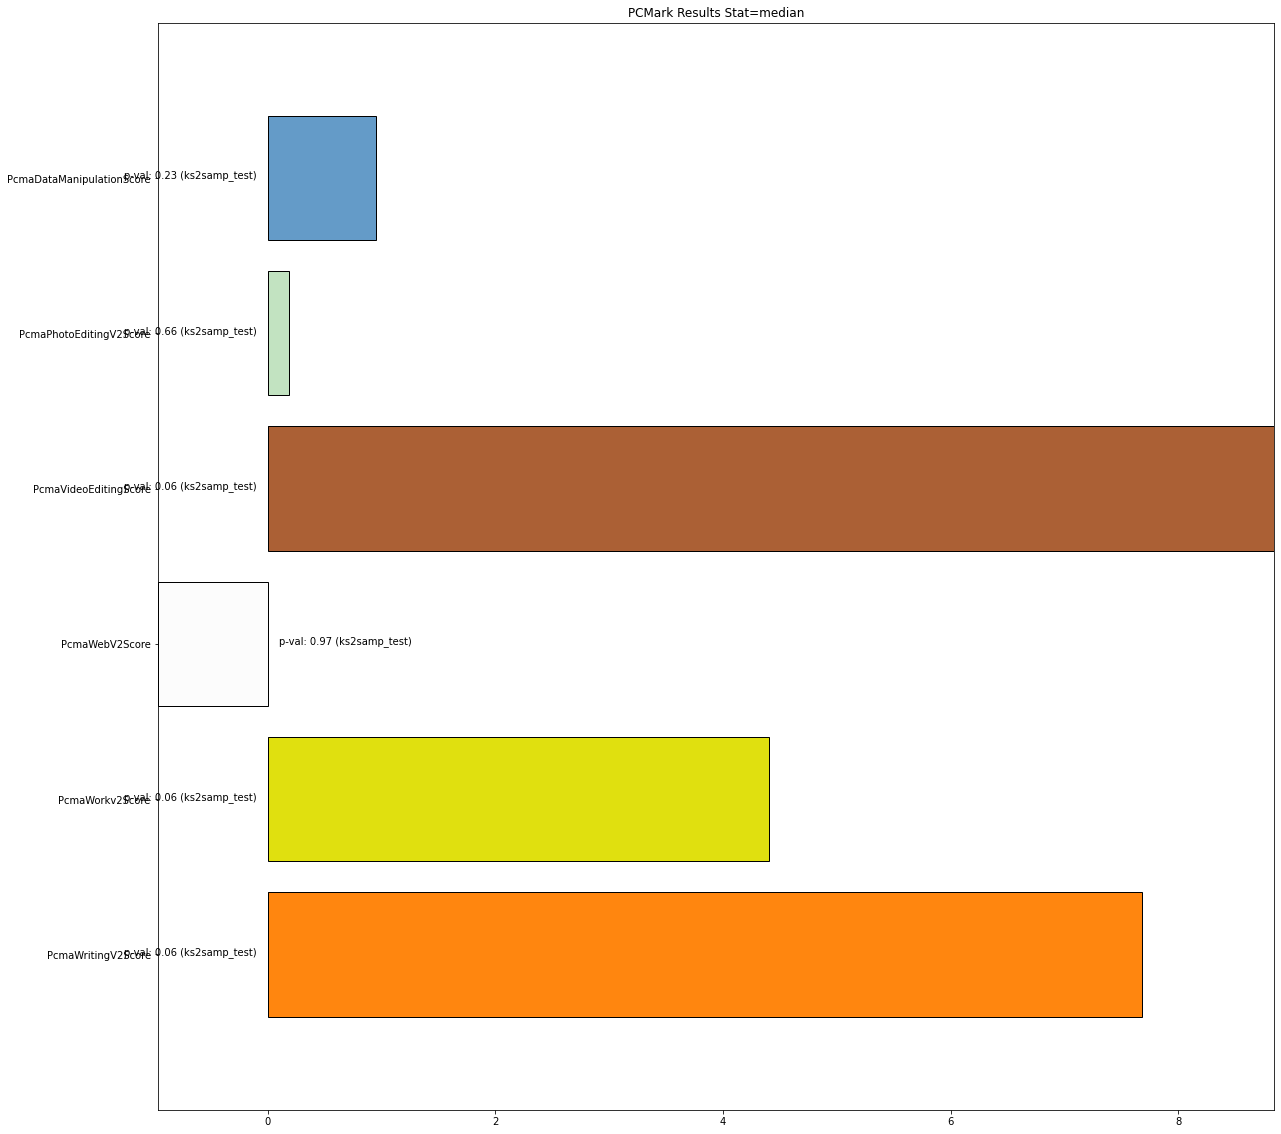

stat,count,ks2samp_test,mean,median,std
metric,,,,,
PcmaDataManipulationScore,33.333333,0.228571,1.563717,0.953926,407.313508
PcmaPhotoEditingV2Score,33.333333,0.657143,0.780159,0.191587,-44.377859
PcmaVideoEditingScore,33.333333,0.057143,8.917572,8.838851,396.265120
PcmaWebV2Score,33.333333,0.971429,-0.415240,-0.964381,3.267948
PcmaWorkv2Score,33.333333,0.057143,3.534400,4.401117,24.673124
PcmaWritingV2Score,33.333333,0.057143,7.256897,7.678781,124.268266


In [24]:
# get list of things to plot
metrics = list(stats.df['metric'].unique())
pcmark_df = stats.df[stats.df['metric'].isin(metrics)]
# reshape and plot
plot_df = pcmark_df.pivot_table(index='metric', columns='stat', values='value')
plot_stats(plot_df, 'PCMark Results', stat='median')
display(plot_df)